# Flight Analysis

In this notebook, we applied data analysis and machine learning techniques to real flight data.
Our objective was to explore, clean, and visualize the dataset to uncover meaningful insights about flight delays, airport performance, and overall flight patterns.
We then developed and evaluated predictive models to estimate the likelihood of flight delays with the goal of improving operational understanding and decision-making.

### Possible questions:

`1.` What factors contribute to both typical and extreme flight departure delays?

`2.` How the delays fluctuate across different time periods?

`3.` Which airports and routes have the highest frequency of delays?

<!-- 
`1.` What drives flight delays? (by airline, origin, destination, time of day)

`2.` Which routes are most/least reliable?

`3.` Seasonal or daily patterns in cancellations or delays

`4.` Are there clusters of similar airports/routes?

`5.` Predict whether a flight will be delayed -->



### Sumary

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import category_encoders as ce

from modules.flight_preprocessor import FlightPreprocessor
from modules.airport_analyzer import AirportAnalyzer

In [2]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()
df_flights = df_flights.fillna(0)

In [3]:
df_flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0


## <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
### `1.` What factors contribute to both typical and extreme flight departure delays?

#### Understanding Variable Correlation

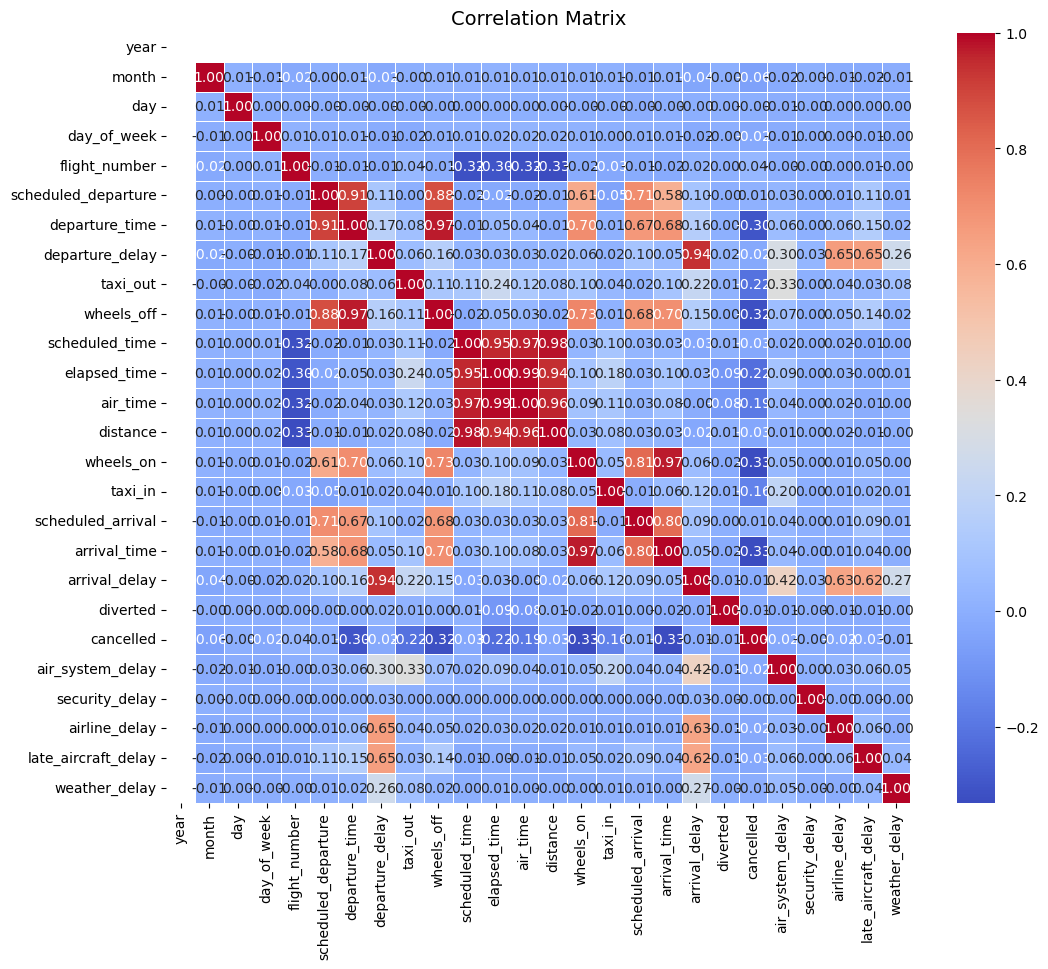

In [4]:
corr = df_flights.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

In [5]:
variables_to_remove = ['flight_number', 'wheels_on', 'wheels_off', 'cancellation_reason', 'tail_number']
df_flights = df_flights.drop(columns=variables_to_remove)

#### Variables with Strong Correlation

Several variables exhibit strong correlations, indicating that they carry redundant or overlapping information.
In other words, they describe similar aspects of the same underlying phenomenon.
To address this, it may be useful to apply dimensionality reduction, either by removing duplicate variables or by combining multiple attributes into a single representative feature.
Some examples include:

- arrival_delay ↔ departure_delay
- schedule_time ↔ elapsed_time ↔ air_time ↔ distance
- arrival_time ↔ wheels_on ↔ scheduled_arrival ↔ wheels_off
- late_aircraft_delay ↔ arrival_delay ↔ airline_delay

Reducing redundancy helps simplify the dataset, improve model interpretability, and prevent overfitting in predictive modeling.

#### Variables with Weak or No Correlation

On the other hand, variables with weak or no correlation show little to no direct relationship between each other.
These features may not significantly contribute to predictive models and could be candidates for removal after further analysis. Examples include:

- flight_number ↔ distance
- flight_number ↔ air_time
- flight_number ↔ elapsed_time
- flight_number ↔ schedule_time

Some relationships also appear weak because the events do not occur together logically — for instance, a canceled flight will not have data for variables related to physical movement:

- cancelled ↔ departure_time
- cancelled ↔ taxi_out
- cancelled ↔ wheels_off
- cancelled ↔ wheels_on
- cancelled ↔ arrival_time

Variable that can be removed:
- flight_number
- wheels_on
- wheels_off
- cancellation_reason

______________________________________

#### Understanding Flight Delays

In [6]:
df_schedules = df_flights[
    (df_flights['diverted'] == 0) & 
    (df_flights['cancelled'] == 0)
][[
    'year', 'month', 'day', 'day_of_week',
    'scheduled_departure', 
    'departure_time', 
    'departure_delay', 
    'scheduled_arrival', 
    'arrival_time', 
    'arrival_delay'
]]
processor = FlightPreprocessor()
df_schedules = processor.preprocess(df_schedules)

In [7]:
# Compute delay metrics
df_schedules['dep_delay_min'] = (df_schedules['departure_time'] - df_schedules['scheduled_departure']).dt.total_seconds() / 60
df_schedules['arr_delay_min'] = (df_schedules['arrival_time'] - df_schedules['scheduled_arrival']).dt.total_seconds() / 60

# Additional derived features
df_schedules['day_of_week'] = df_schedules['scheduled_departure'].dt.day_name()
df_schedules['hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['is_delayed'] = df_schedules['dep_delay_min'] > 15

df_schedules['scheduled_hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['departure_hour'] = df_schedules['departure_time'].dt.hour
df_schedules['arrival_hour'] = df_schedules['arrival_time'].dt.hour


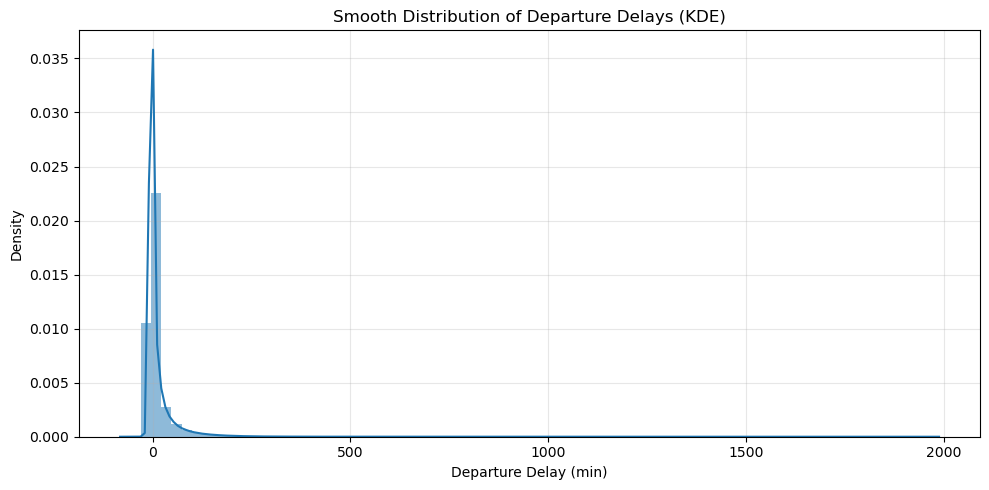

In [8]:
delays = df_schedules['departure_delay'].dropna()
plt.figure(figsize=(10,5))
sns.histplot(
    delays,
    bins=80,
    kde=True,
    stat="density",
    edgecolor=None
)

plt.title("Smooth Distribution of Departure Delays (KDE)")
plt.xlabel("Departure Delay (min)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
threshold = 120
df_flights['is_outlier'] = df_flights['departure_delay'] > threshold

Q1 = df_flights['departure_delay'].quantile(0.25)
Q3 = df_flights['departure_delay'].quantile(0.75)
IQR = Q3 - Q1

df_flights['is_outlier'] = df_flights['departure_delay'] > (Q3 + 1.5*IQR)

delay_vars = [
    'airline_delay',
    'late_aircraft_delay',
    'air_system_delay',
    'weather_delay',
    'security_delay'
]

outlier_mean = df_flights[df_flights['is_outlier']][delay_vars].mean()
normal_mean = df_flights[~df_flights['is_outlier']][delay_vars].mean()

comparison = pd.DataFrame({
    'Normal Flights': normal_mean,
    'Outlier Flights': outlier_mean
})

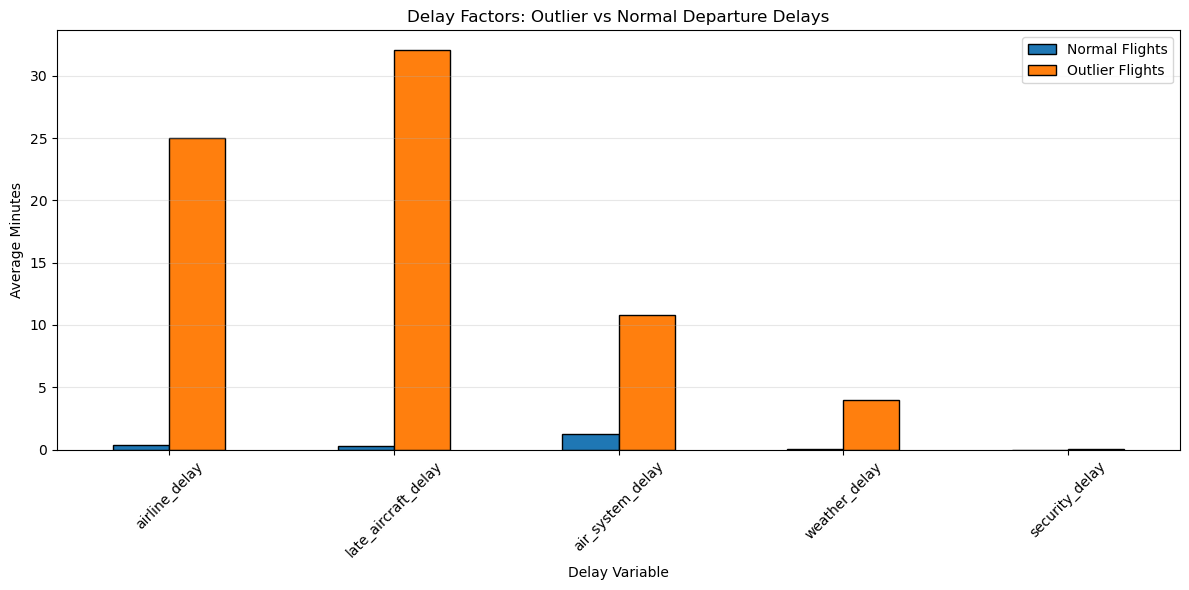

In [10]:
comparison.plot(kind='bar', figsize=(12,6), edgecolor='black')

plt.title("Delay Factors: Outlier vs Normal Departure Delays")
plt.xlabel("Delay Variable")
plt.ylabel("Average Minutes")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#### Overall Distribution of Delays

Most flights depart on time or even ahead of schedule, showing that delays are not typically caused by routine scheduling issues. Only a small portion of flights experiences significant disruptions. Among these, a few extreme cases stand out, with departures occurring more than 33 hours later than planned. Even so, none of these flights were marked as cancelled, meaning the delays were severe but not terminal to the operation.

#### Main Causes of Flight Delays

When we focus specifically on the flights with the longest delays, we see that they are strongly associated with identifiable operational and environmental causes. The main factors contributing to delays include:

- Airline Delay — Internal issues within the airline, such as maintenance, crew scheduling, or logistical problems.

- Late Aircraft Delay — A delayed incoming aircraft that prevents the next flight from departing on time.

- Air System Delay — Air traffic control restrictions, system congestion, or other national airspace management constraints.

- Weather Delay — Adverse conditions like storms, low visibility, snow, or strong winds that limit safe operations.

______________________________________

### `2.` How the delays fluctuate across different time periods?

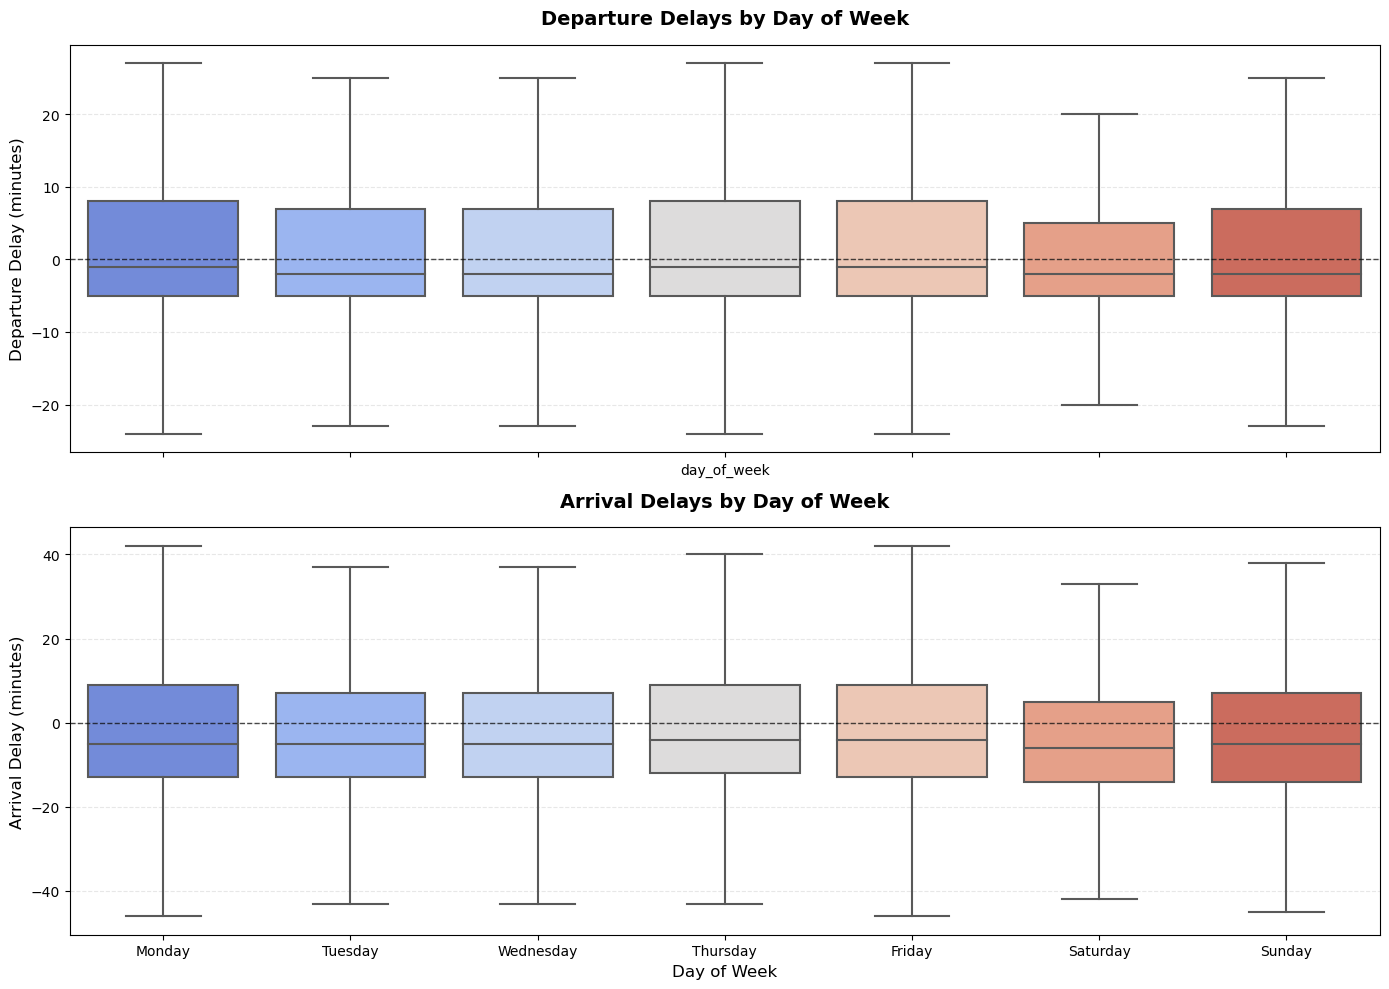

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Ensure correct ordering of days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_schedules['day_of_week'] = pd.Categorical(df_schedules['day_of_week'], categories=day_order, ordered=True)

# --- First plot: Departure delays ---
sns.boxplot(
    ax=axes[0],
    x='day_of_week',
    y='dep_delay_min',
    data=df_schedules,
    showfliers=False
)
axes[0].set_title('Departure Delays by Day of Week', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Departure Delay (minutes)', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# --- Second plot: Arrival delays ---
sns.boxplot(
    ax=axes[1],
    x='day_of_week',
    y='arr_delay_min',
    data=df_schedules,
    showfliers=False
)
axes[1].set_title('Arrival Delays by Day of Week', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Day of Week', fontsize=12)
axes[1].set_ylabel('Arrival Delay (minutes)', fontsize=12)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


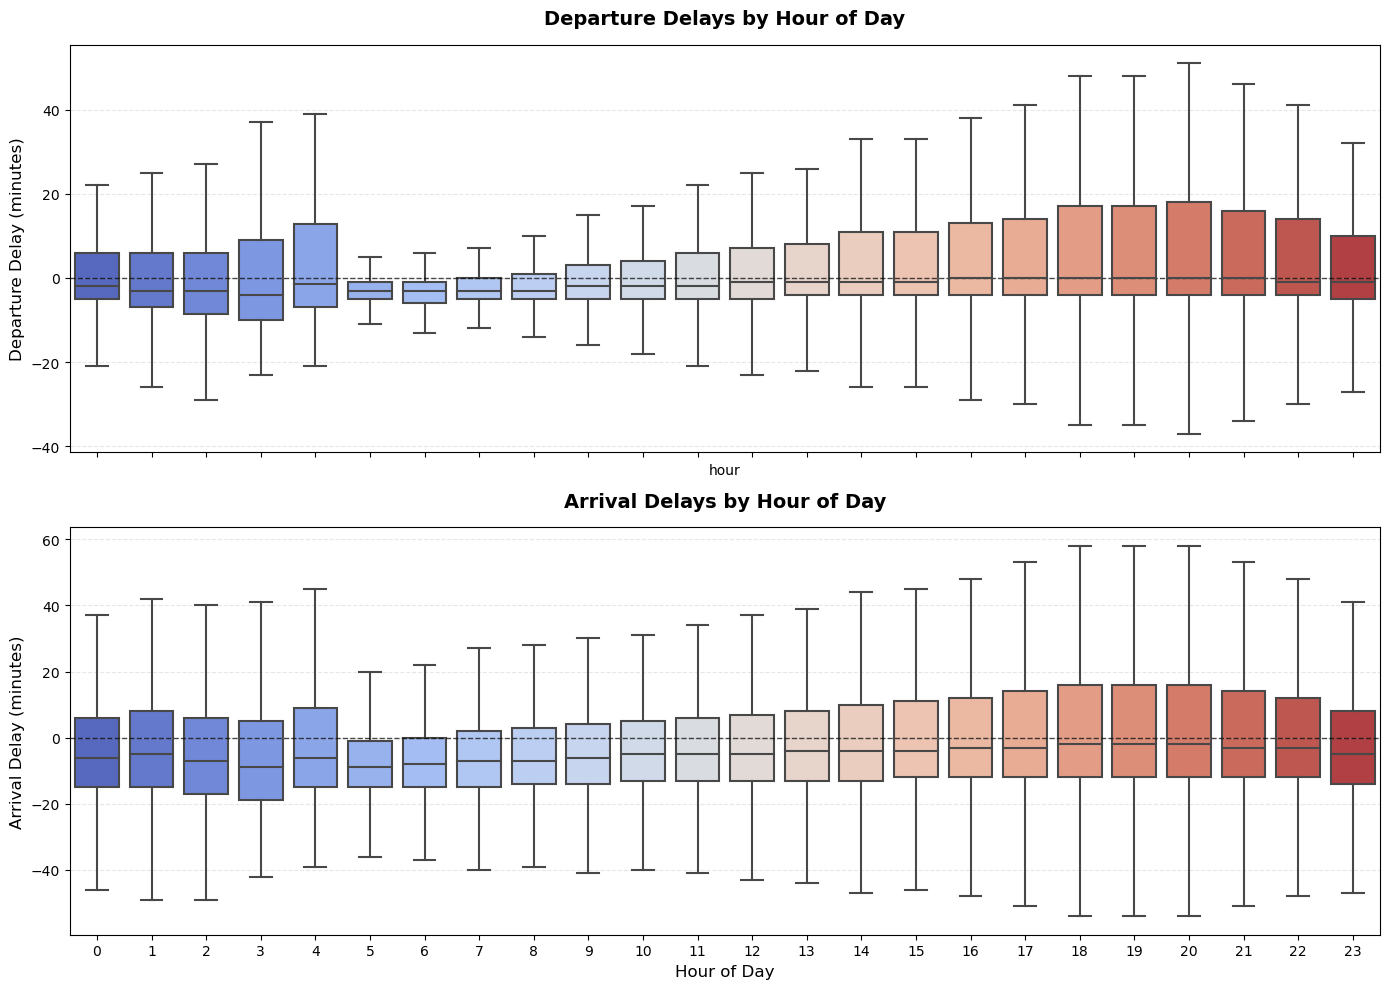

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- First plot: Departure delays ---
sns.boxplot(
    ax=axes[0],
    x='hour',
    y='dep_delay_min',
    data=df_schedules,
    showfliers=False
)
axes[0].set_title('Departure Delays by Hour of Day', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Departure Delay (minutes)', fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# --- Second plot: Arrival delays ---
sns.boxplot(
    ax=axes[1],
    x='hour',
    y='arr_delay_min',
    data=df_schedules,
    showfliers=False
)
axes[1].set_title('Arrival Delays by Hour of Day', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Arrival Delay (minutes)', fontsize=12)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


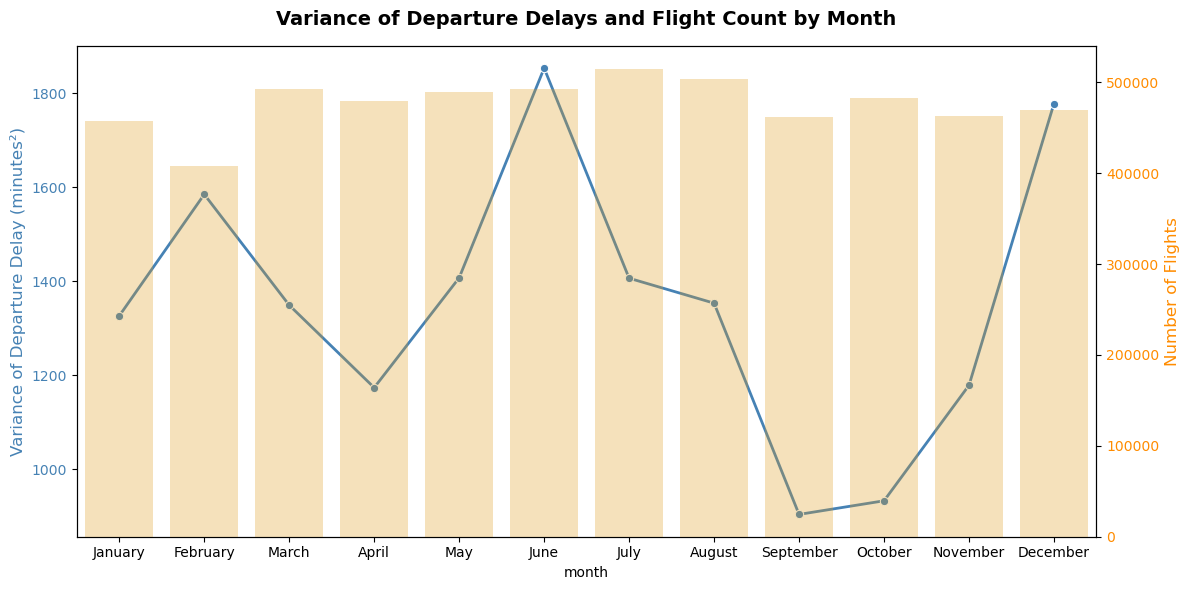

In [13]:
df_schedules['month'] = df_schedules['scheduled_departure'].dt.month_name()
monthly_stats = (
    df_schedules.groupby('month')['dep_delay_min']
    .agg(['var', 'count'])
    .reset_index()
)

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

monthly_stats['month'] = pd.Categorical(monthly_stats['month'], categories=month_order, ordered=True)
monthly_stats = monthly_stats.sort_values('month')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Variance
sns.lineplot(
    data=monthly_stats,
    x='month',
    y='var',
    marker='o',
    color='steelblue',
    linewidth=2,
    ax=ax1
)
ax1.set_ylabel('Variance of Departure Delay (minutes²)', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Flight count
ax2 = ax1.twinx()
sns.barplot(
    data=monthly_stats,
    x='month',
    y='count',
    alpha=0.3,
    color='orange',
    ax=ax2
)
ax2.set_ylabel('Number of Flights', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Variance of Departure Delays and Flight Count by Month', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


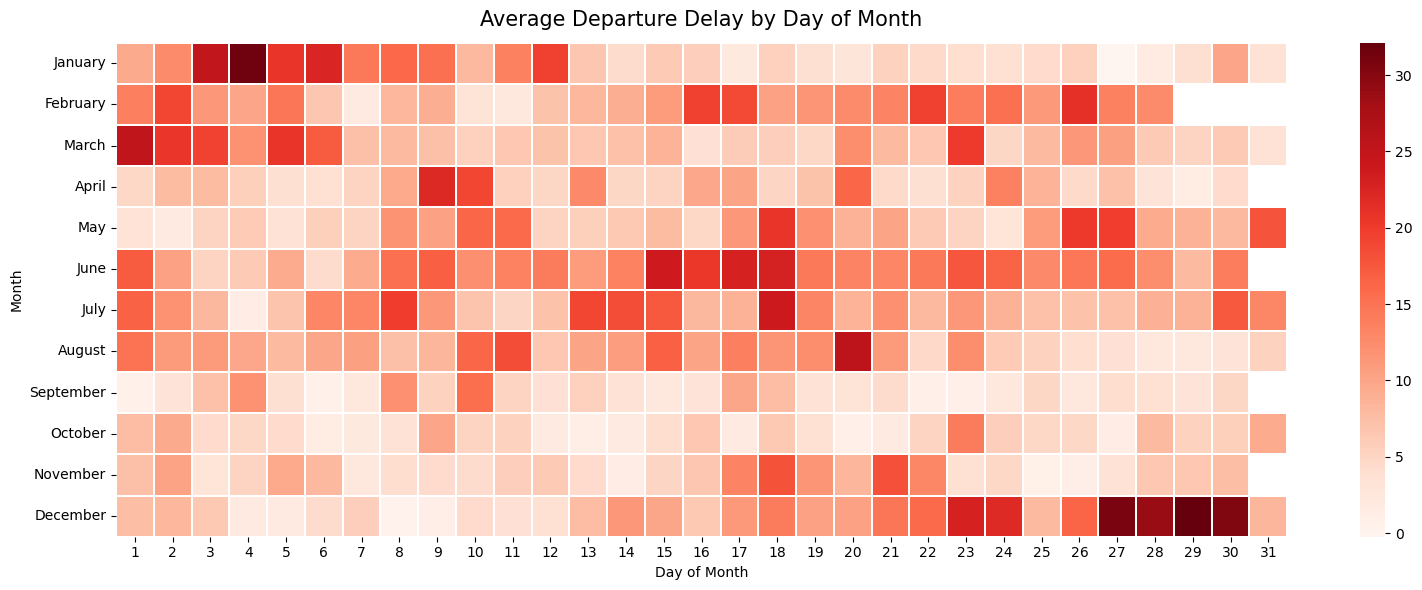

In [14]:
delay_matrix = (
    df_schedules.groupby(['month', 'day'])['dep_delay_min']
    .mean()
    .reset_index()
)

# Apply month ordering as categorical
delay_matrix['month'] = pd.Categorical(
    delay_matrix['month'],
    categories=month_order,
    ordered=True
)

# Sort properly
delay_matrix = delay_matrix.sort_values(['month', 'day'])

# Pivot for heatmap
pivot = delay_matrix.pivot(index='month', columns='day', values='dep_delay_min')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap="Reds", linewidths=0.2)
plt.title("Average Departure Delay by Day of Month", fontsize=15, pad=12)
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


#### Delay Behavior Across Days and Hours

When analyzing flight delays across both days and hours, we find that the day of the week has very little influence on delay patterns. In other words, Mondays are not consistently better or worse than Fridays in terms of overall delay behavior.

However, when delays are examined hour by hour, the patterns become much more dynamic. As the day progresses, delay variance steadily increases, reflecting how operational disruptions accumulate over time. Early-day delays can cascade through the schedule, affecting aircraft rotations, crew availability, and airport congestion, ultimately increasing variability later in the day.

This cascading effect is a well-known phenomenon in airline operations: a single early delay can propagate through multiple subsequent flights, amplifying overall disruption.

#### Variability Over the Year

Looking at a broader yearly perspective, the number of flights per month stays relatively stable, indicating that fluctuations in delay behavior are not simply due to volume changes.

Even with stable flight counts, delay variability shifts significantly across specific periods of the year. Many of the spikes align with major U.S. holiday seasons, which is consistent with the geographic scope of the dataset. Higher passenger loads, increased air traffic, and weather challenges often coincide during those times.

One of the most prominent peaks occurs between late December and early January, driven by the year-end holidays and compounded by harsh winter weather conditions, which frequently disrupt operations.

We also observe elevated delay variability during the summer months, a period characterized by high travel demand and weather patterns such as thunderstorms, convective activity, and heat-related operational constraints. These factors contribute to increased delays even though flight volumes remain fairly steady.

### `3.` Which airports and routes have the highest frequency of delays?

In [15]:
df_airports = pd.read_csv("./data/airports.csv", low_memory=False)
df_airports.columns = df_airports.columns.str.lower()
df_airports = df_airports[['iata_code', 'latitude','longitude', 'city', 'state', 'country']]
df_airport_flights = df_flights[
    (df_flights['diverted'] == 0) & 
    (df_flights['cancelled'] == 0)
][['origin_airport','destination_airport', 'month']]

In [16]:
analyzer = AirportAnalyzer(df_flights, df_airports)
airport_metrics = analyzer.compute_airport_metrics()
routes_metrics = analyzer.compute_route_metrics()

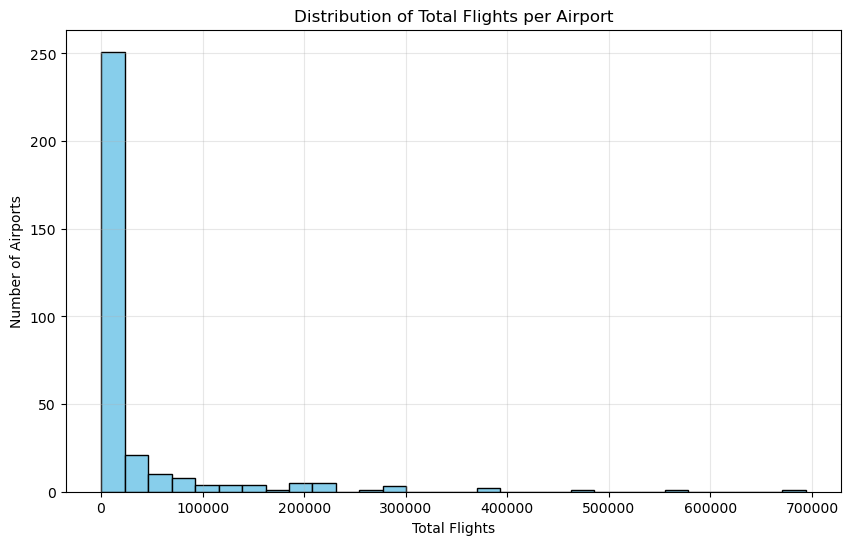

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(analyzer.df_metrics['total_flights'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Flights per Airport')
plt.xlabel('Total Flights')
plt.ylabel('Number of Airports')
plt.grid(alpha=0.3)
plt.show()

In [18]:
airport_metrics.head(10)

,iata_code,latitude,longitude,city,state,country,departures,arrivals,total_flights,avg_arrival_delay,avg_departure_delay
0,ATL,33.64044,-84.42694,Atlanta,GA,USA,346836.0,346904,693740.0,2.201696,9.274660
1,ORD,41.97960,-87.90446,Chicago,IL,USA,285884.0,285906,571790.0,6.986482,13.748639
2,DFW,32.89595,-97.03720,Dallas-Fort Worth,TX,USA,239551.0,239582,479133.0,5.674817,11.245209
3,DEN,39.85841,-104.66700,Denver,CO,USA,196055.0,196010,392065.0,5.005724,11.716605
4,LAX,33.94254,-118.40807,Los Angeles,CA,USA,194673.0,194696,389369.0,6.029235,10.555526
5,SFO,37.61900,-122.37484,San Francisco,CA,USA,148008.0,147966,295974.0,6.468216,11.035214
6,PHX,33.43417,-112.00806,Phoenix,AZ,USA,146815.0,146812,293627.0,2.883695,8.619964
7,IAH,29.98047,-95.33972,Houston,TX,USA,146622.0,146683,293305.0,5.531963,11.424998
8,LAS,36.08036,-115.15233,Las Vegas,NV,USA,133181.0,133198,266379.0,3.581435,10.881064
9,MSP,44.88055,-93.21692,Minneapolis,MN,USA,112117.0,112128,224245.0,3.344811,7.206936


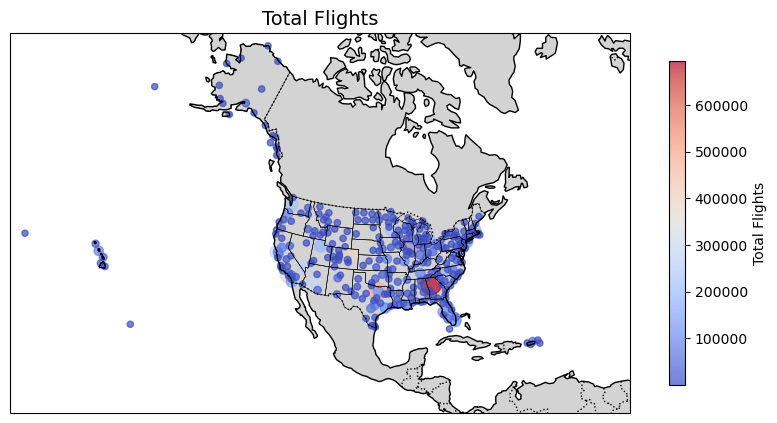

In [19]:
analyzer.plot_airports('total_flights', title='Total Flights')

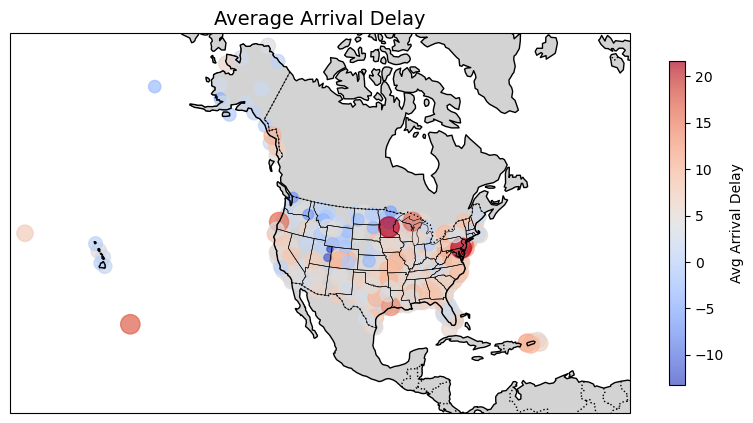

In [20]:
analyzer.plot_airports('avg_arrival_delay', title='Average Arrival Delay')

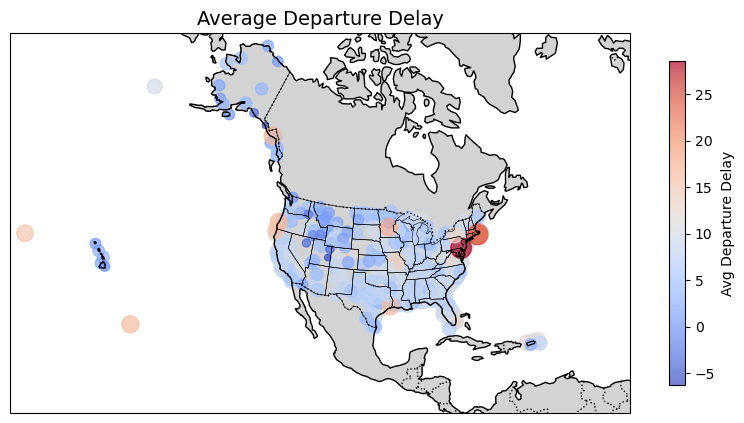

In [21]:
analyzer.plot_airports('avg_departure_delay', title='Average Departure Delay')

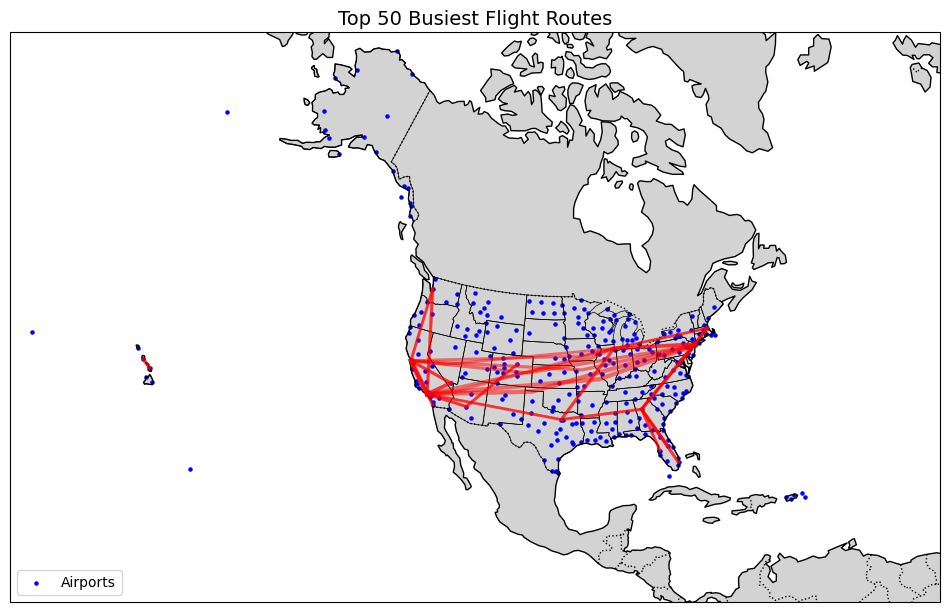

In [22]:
analyzer.plot_top_routes(top_n=50)

posx and posy should be finite values
posx and posy should be finite values


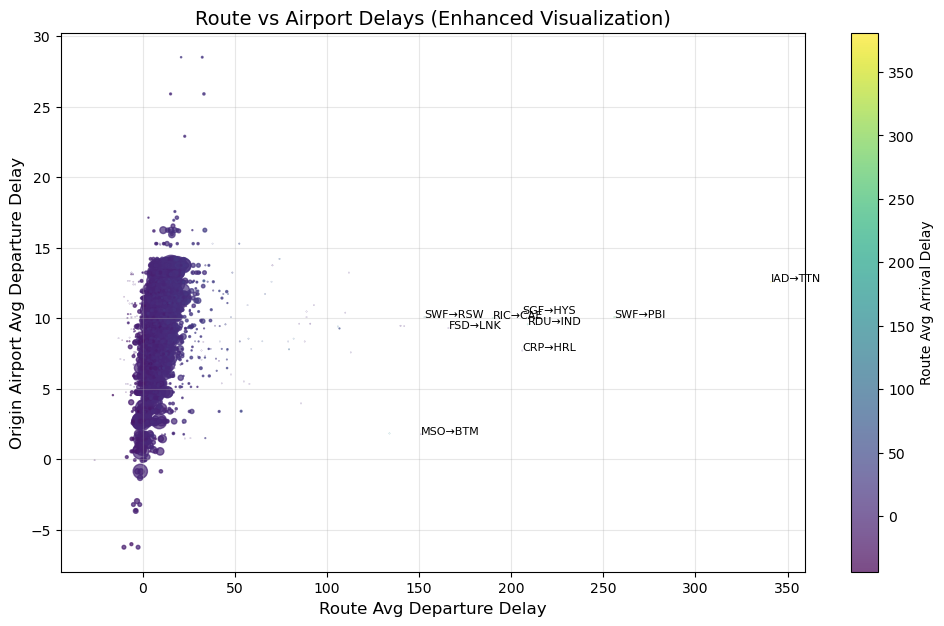

In [23]:
merged = routes_metrics.merge(
    airport_metrics[['iata_code', 'avg_departure_delay', 'avg_arrival_delay']],
    left_on='origin_airport',
    right_on='iata_code',
    how='left',
    suffixes=('_route', '_airport')
)

sizes = merged['total_flights'] / merged['total_flights'].max() * 300

colors = merged['avg_arrival_delay_route']

plt.figure(figsize=(12, 7))

scatter = plt.scatter(
    merged['avg_departure_delay_route'],
    merged['avg_departure_delay_airport'],
    s=sizes,
    c=colors,
    alpha=0.7
)

plt.xlabel("Route Avg Departure Delay", fontsize=12)
plt.ylabel("Origin Airport Avg Departure Delay", fontsize=12)
plt.title("Route vs Airport Delays (Enhanced Visualization)", fontsize=14)

# Add colorbar for interpretation
cbar = plt.colorbar(scatter)
cbar.set_label("Route Avg Arrival Delay")

plt.grid(True, alpha=0.3)

# Label the worst 10 routes (by route departure delay)
worst = merged.nlargest(10, 'avg_departure_delay_route')

for _, row in worst.iterrows():
    plt.text(
        row['avg_departure_delay_route'],
        row['avg_departure_delay_airport'],
        f"{row['origin_airport']}→{row['destination_airport']}",
        fontsize=8,
        ha='left'
    )

plt.show()

posx and posy should be finite values
posx and posy should be finite values


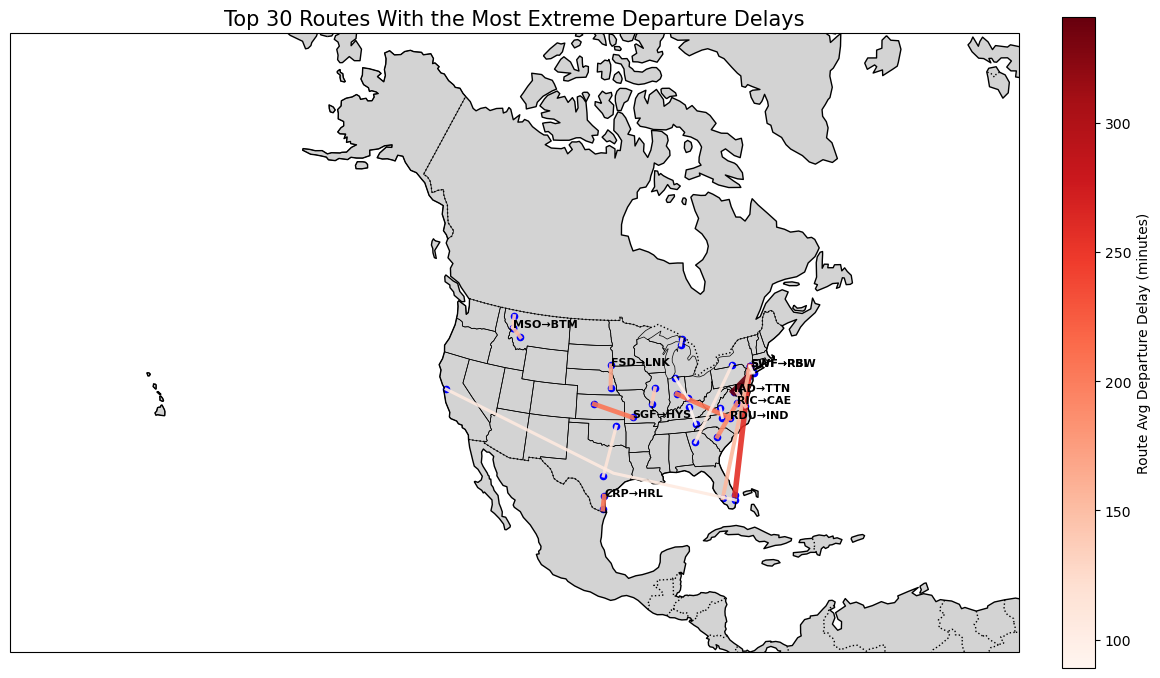

In [24]:
analyzer.plot_extreme_route_delays(top_n=30)

When analyzing total flight volume, we observe a highly uneven distribution: most airports operate only a small number of flights, while a few major hubs—such as Atlanta, Chicago, Dallas, Denver, Los Angeles, and San Francisco—handle a disproportionately large share of all traffic. Despite this imbalance, comparing flight volume with delay patterns reveals no strong relationship. High-traffic airports are not necessarily those with the highest delay rates, suggesting that airport size alone does not determine how frequently delays occur.

Looking at routes, the most frequent ones tend to connect major U.S. hubs, reflecting the key corridors of the national air transportation network. When we examine delays in this context, we find that most routes mirror the delay behavior of their respective airports. However, some outliers stand out—for example, IAD → TTN and SWF → PBI—where delays are significantly higher than expected based on airport-level patterns.

Finally, when focusing on the regions with the highest delay concentrations, a clear connection emerges: airports and routes experiencing more delays are often clustered within the same geographic areas, indicating shared operational or environmental factors influencing performance.